In [26]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import os

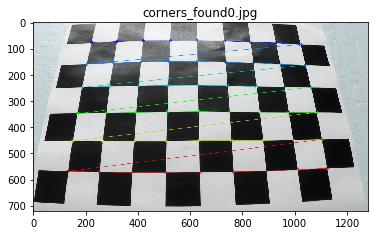

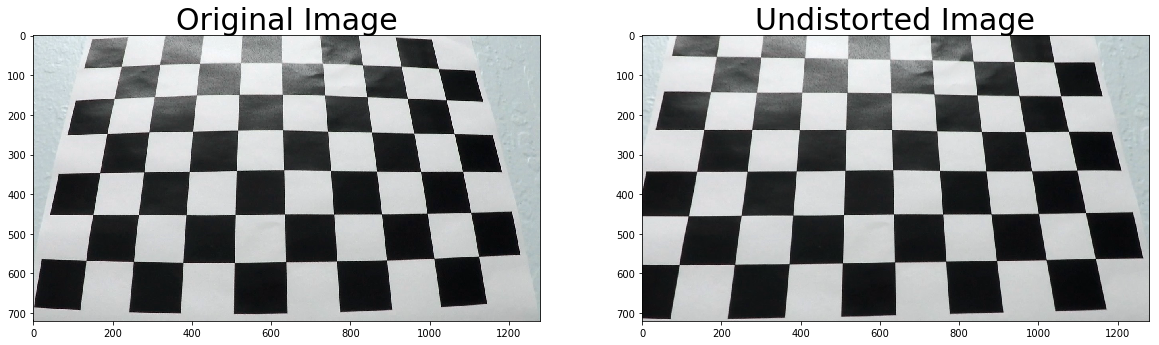

In [12]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration3.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images[0:1]):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    #print(fname + str(ret))
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'corners_found'+str(idx)+'.jpg'
        plt.title(write_name)
        plt.imshow(img)
        cv2.waitKey(500)


# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
#cv2.imwrite('./camera_cal/calibration2_undist.jpg',dst)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [14]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    #print(ret)
    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

True


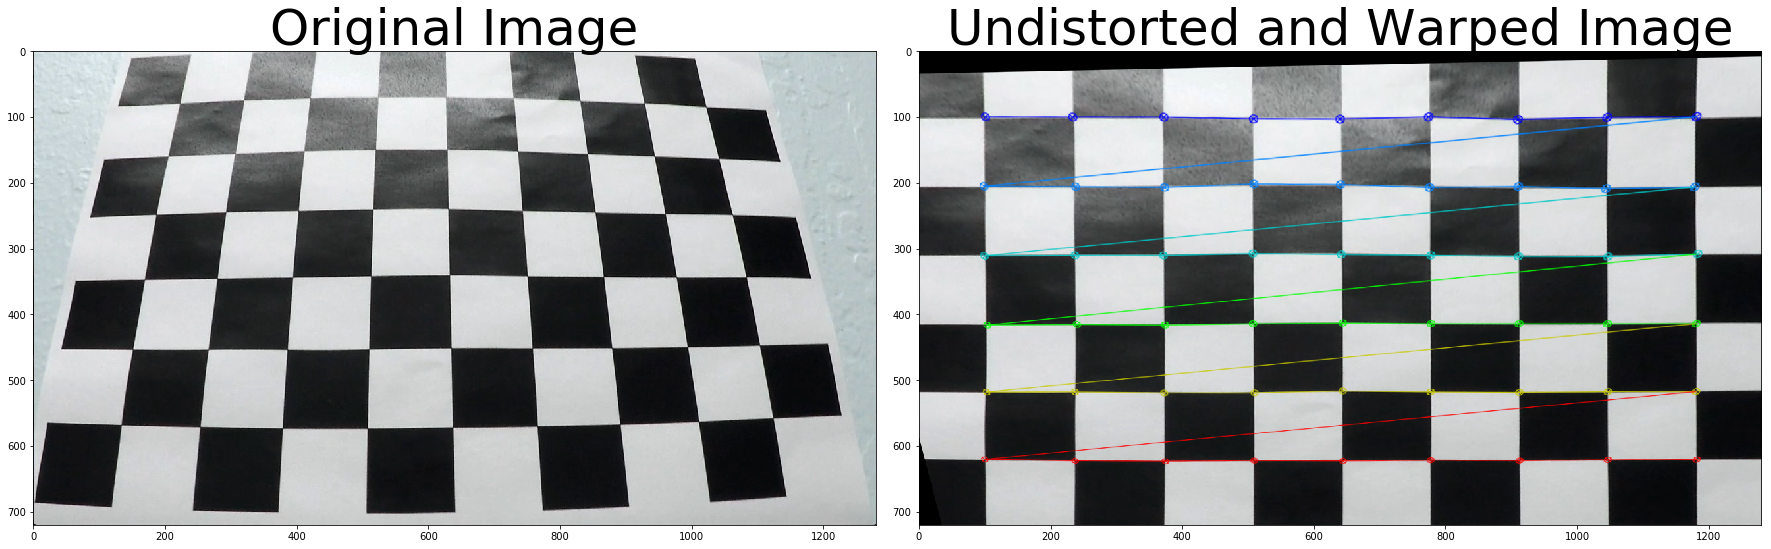

In [13]:
img = cv2.imread('./camera_cal/calibration3.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
img_size = (img.shape[1], img.shape[0])
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [15]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


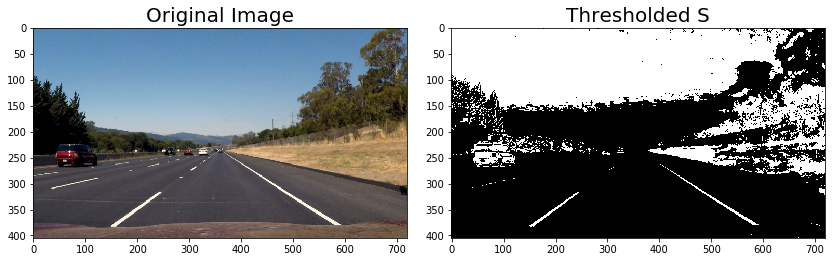

In [55]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# Read in an image
image = mpimg.imread('test_images/straight_lines2.jpg')
image = cv2.resize(image,(720,405))


hls_binary = hls_select(image, thresh=(90, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

test_images/straight_lines1.jpg
test_images/straight_lines2.jpg
test_images/test1.jpg
test_images/test2.jpg
test_images/test3.jpg
test_images/test4.jpg
test_images/test5.jpg


/Users/govindaputhalapat/anaconda/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


test_images/test6.jpg


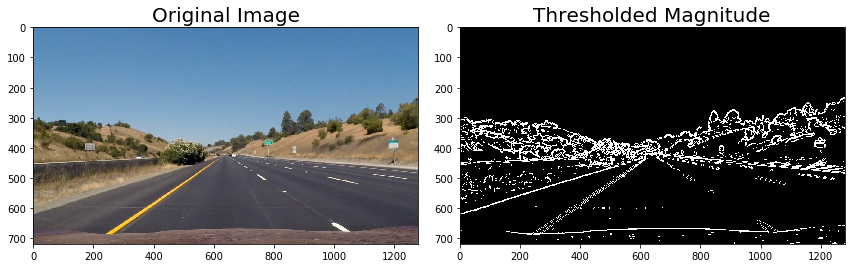

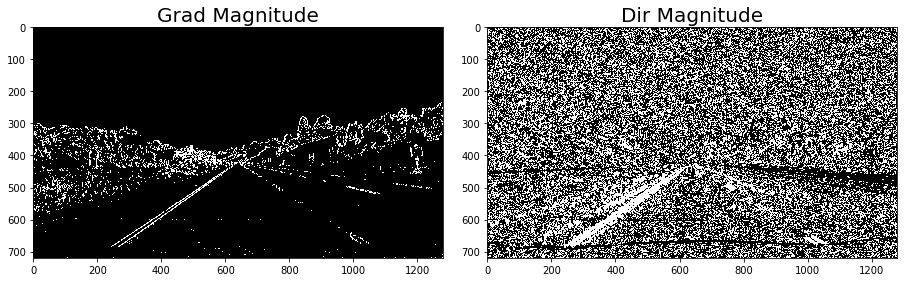

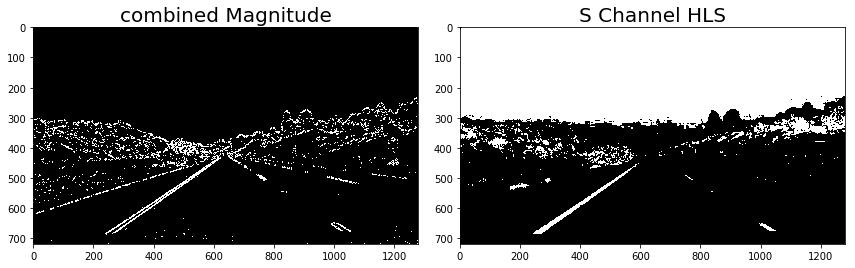

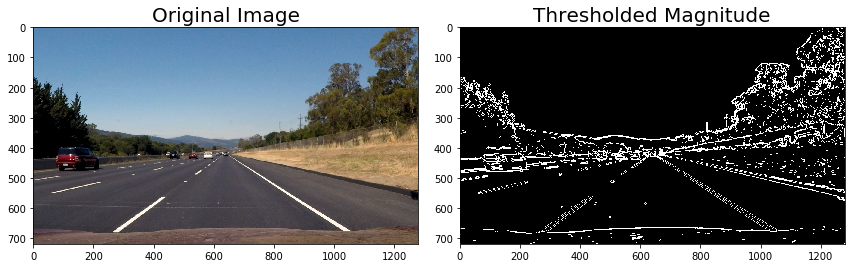

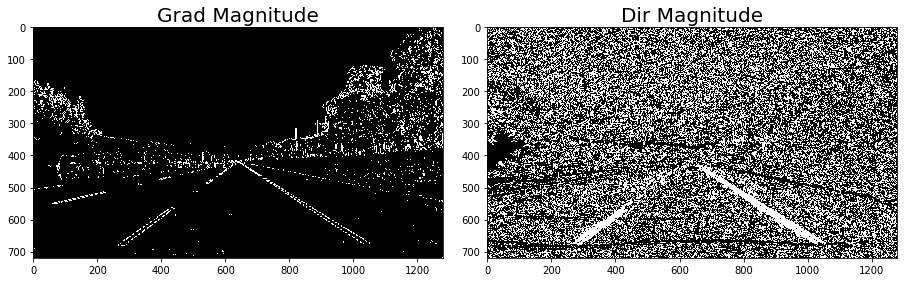

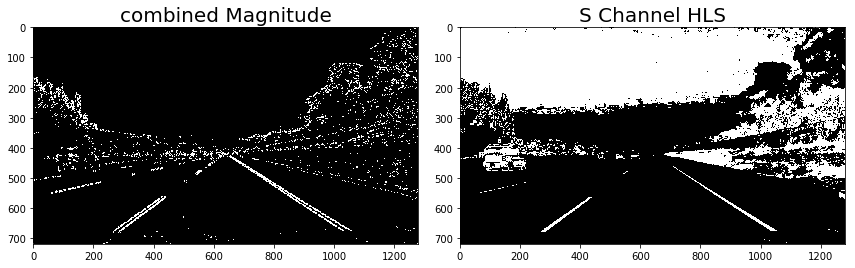

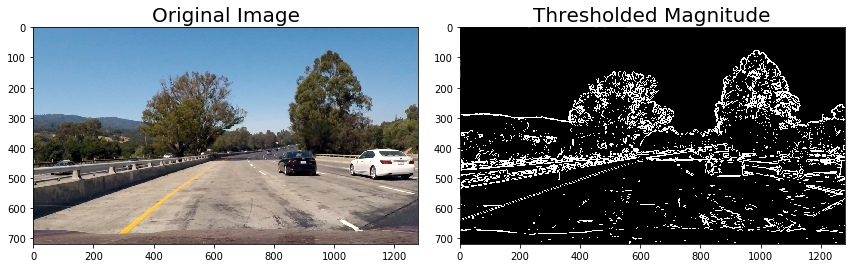

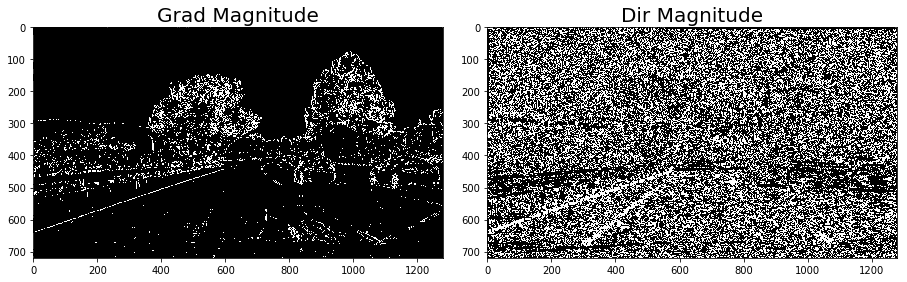

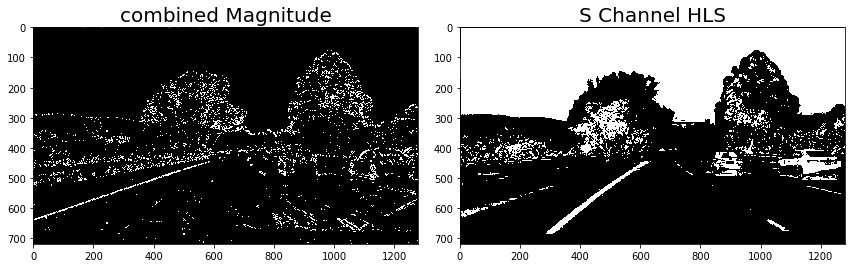

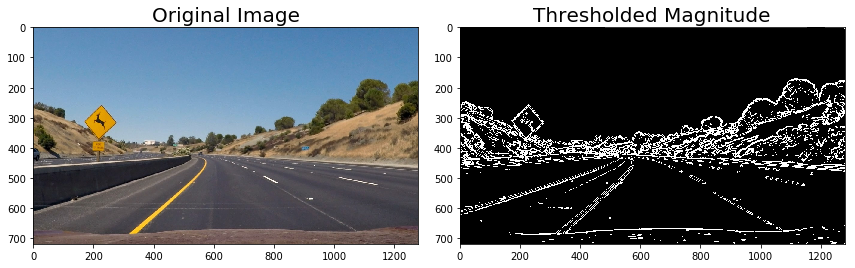

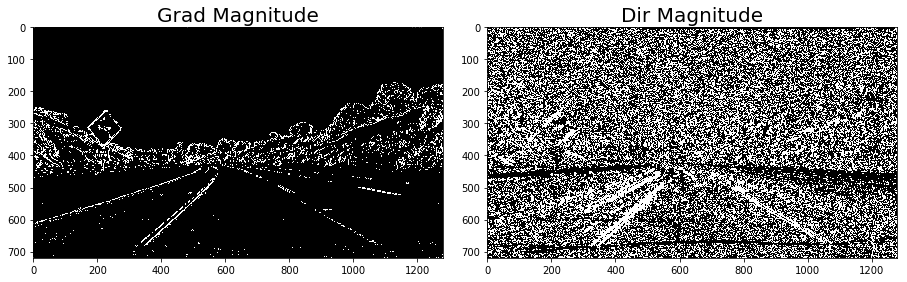

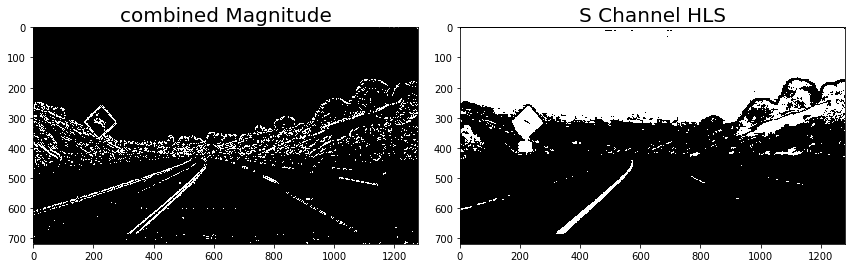

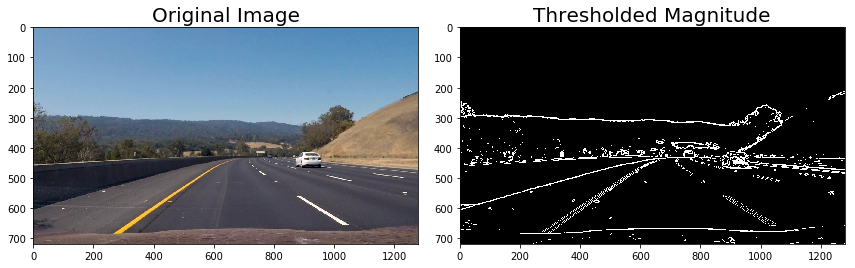

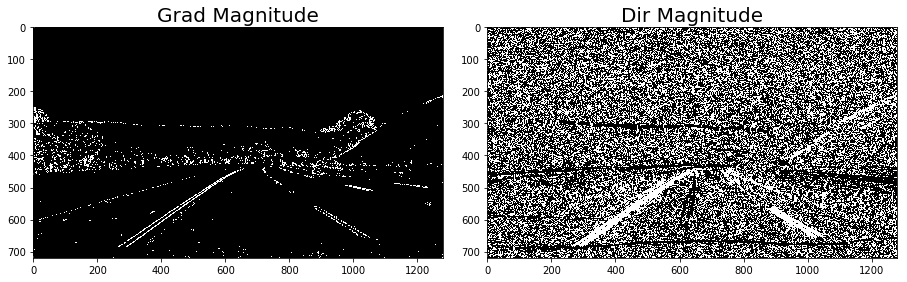

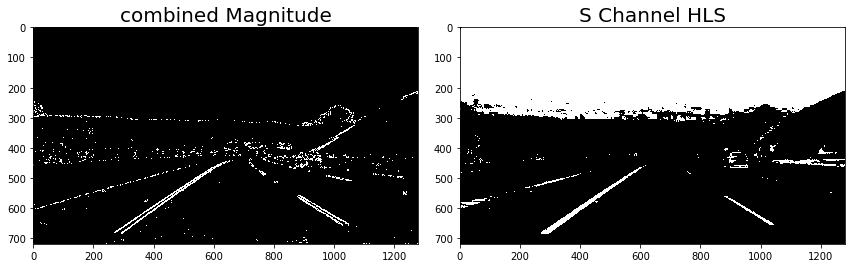

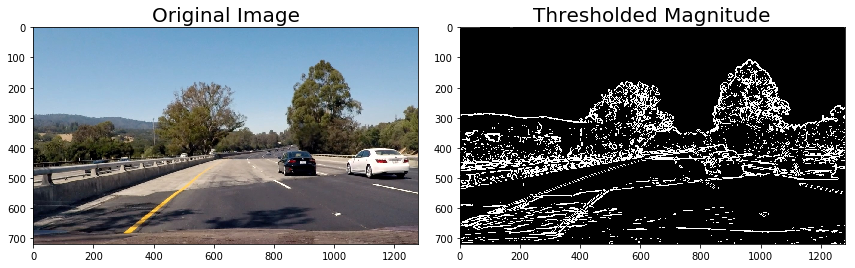

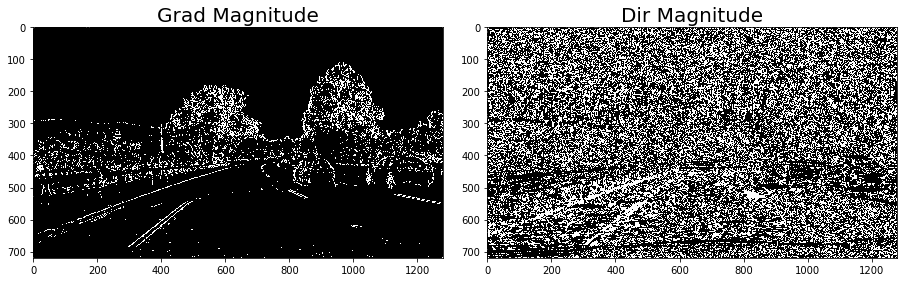

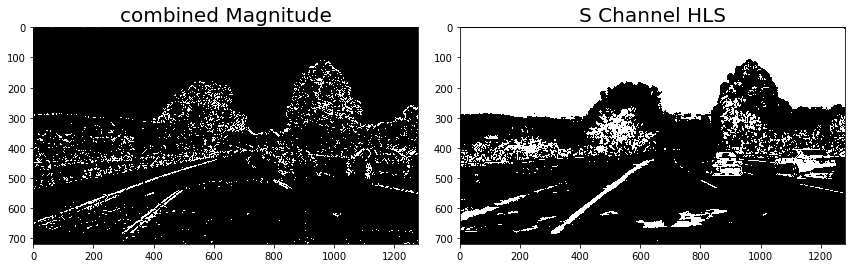

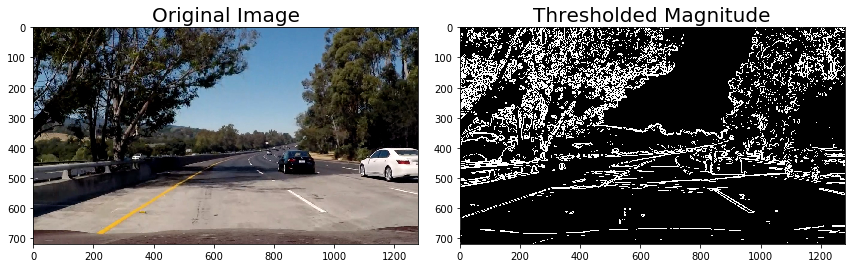

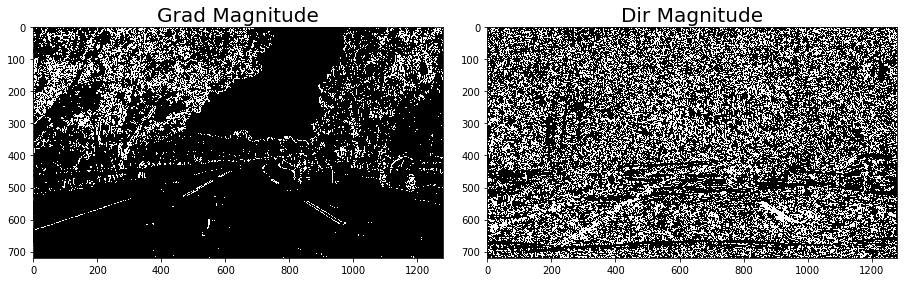

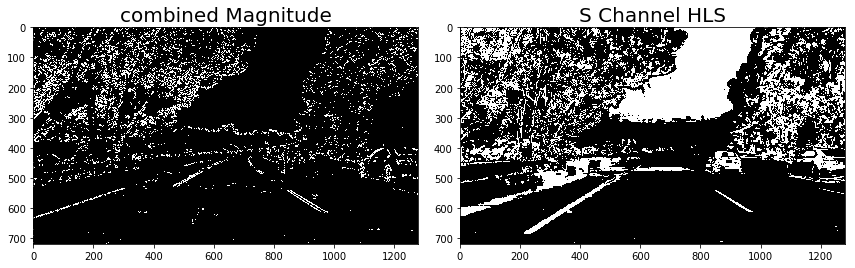

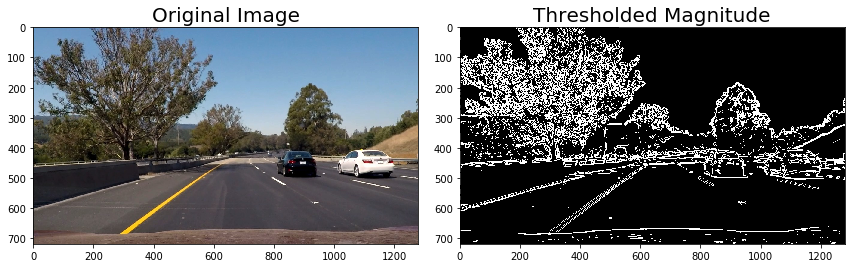

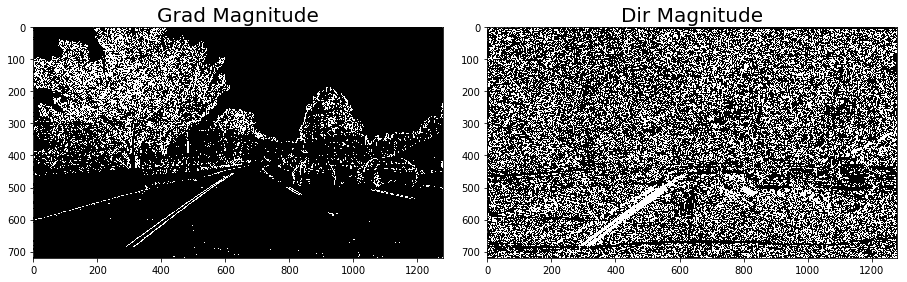

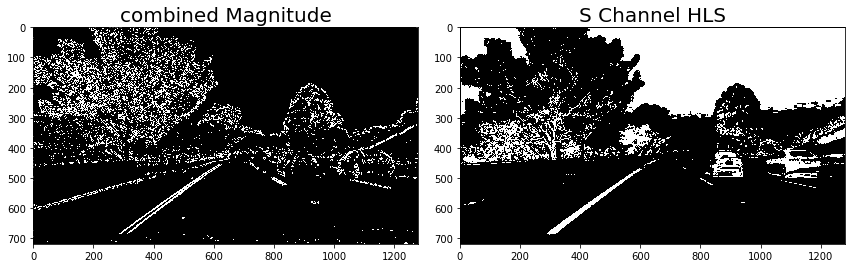

In [78]:
images = os.listdir('./test_images')  
for fname in images:
    fname = os.path.join('test_images',fname)
    image = mpimg.imread(fname)
    # Run the function
    print(fname)
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))

    # Run the function
    grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)

    # Run the function
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=255)
    grady = abs_sobel_thresh(image, orient='y', thresh_min=20, thresh_max=255)
    #mag_binaryt = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(0, 255))
    #dir_binaryt = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))
    hls_binary = hls_select(image, thresh=(90, 255))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    # Plot the result
    figsize=(12,5)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(mag_binary, cmap='gray')
    ax2.set_title('Thresholded Magnitude', fontsize=20)
    f, (ax3, ax4) = plt.subplots(1, 2, figsize=figsize)
    f.tight_layout()
    ax3.imshow(grad_binary, cmap='gray')
    ax3.set_title('Grad Magnitude', fontsize=20)
    ax4.imshow(dir_binary, cmap='gray')
    ax4.set_title('Dir Magnitude', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    f, (ax5, ax6) = plt.subplots(1, 2, figsize=figsize)
    f.tight_layout()
    ax5.imshow(combined, cmap='gray')
    ax5.set_title('combined Magnitude', fontsize=20)
    ax6.imshow(hls_binary, cmap='gray')
    ax6.set_title('S Channel HLS', fontsize=20)

In [94]:
# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary
 
def pipeline2(image):    
    # Run the function
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))

    # Run the function
    grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)

    # Run the function
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=255)
    grady = abs_sobel_thresh(image, orient='y', thresh_min=20, thresh_max=255)

    hls_binary = hls_select(image, thresh=(90, 255))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    combined2 = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grad_binary == 1) & (hls_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined2[((hls_binary == 1) & (dir_binary ==1)) | ((combined == 1) & (dir_binary ==1)) | (grad_binary == 1)] = 1
    return combined2

In [196]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def lane_corners_unwarp(img, nx=nx, ny=ny, mtx=mtx, dist=dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Choose offset from image corners to plot detected corners
    # This should be chosen to present the result at the proper aspect ratio
    # My choice of 100 pixels is not exact, but close enough for our purpose here
    area_of_interest = [[150+430,460],[1150-440,460],[1150,720],[150,720]]
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])

    # Choose an offset from image corners to plot detected corners
    offset1 = 200 # offset for dst points x value
    offset2 = 0 # offset for dst points bottom y value
    offset3 = 0 # offset for dst points top y value
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])
    # For source points I'm grabbing the outer four detected corners
    src = np.float32(area_of_interest)
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    dst = np.float32([[offset1, offset3], 
                      [img_size[0]-offset1, offset3], 
                      [img_size[0]-offset1, img_size[1]-offset2], 
                      [offset1, img_size[1]-offset2]])

    #apex, apey = 360, 258
    #offset_far = 50
    #offset_near = 10
    #src = np.float32([[int(apex-offset_far),apey],
    #                  [int(apex+offset_far),apey],
    #                  [int(0+offset_near),390],
    #                  [int(720-offset_near),390]])
    #dst = np.float32([[0,0],[720,0],[0,405],[720,405]])
    #offset = 100 # offset for dst points

    # For source points I'm grabbing the outer four detected corners
    #src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    #dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
    #                             [img_size[0]-offset, img_size[1]-offset], 
    #                             [offset, img_size[1]-offset]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv

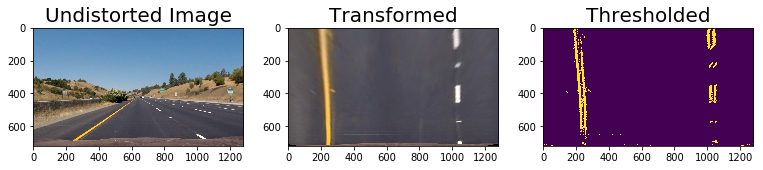

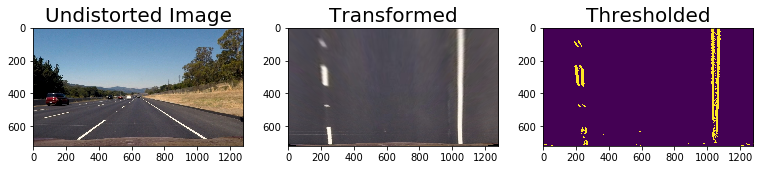

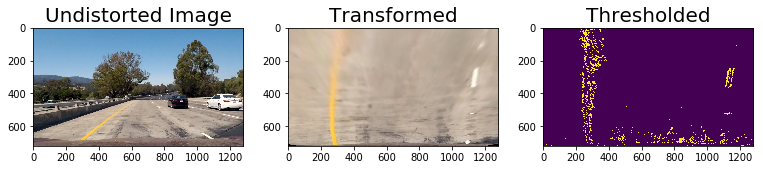

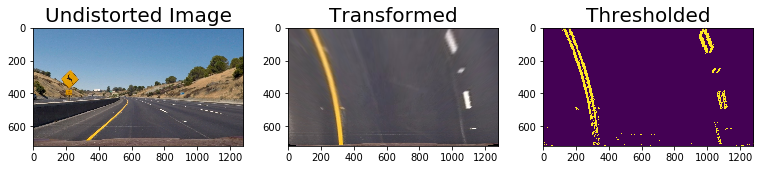

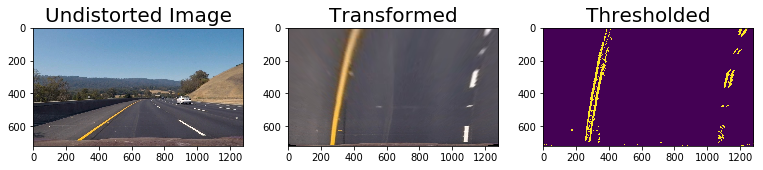

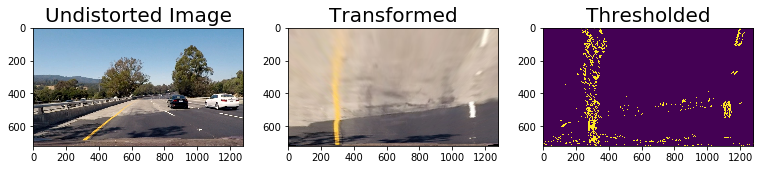

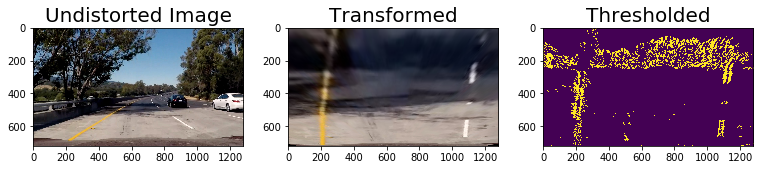

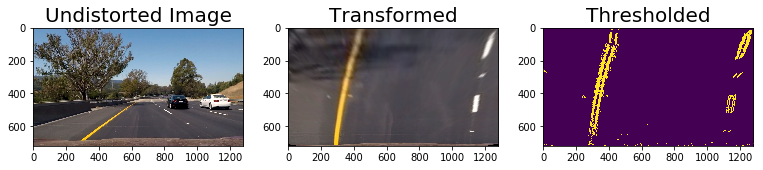

In [197]:
images = os.listdir('./test_images')  
for fname in images:
    fname = os.path.join('test_images',fname)
    img = mpimg.imread(fname)
    warped, M, Minv = lane_corners_unwarp(img)
    thresholded = pipeline2(warped)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Undistorted Image', fontsize=20)
    ax2.imshow(warped)
    ax2.set_title('Transformed', fontsize=20)
    ax3.imshow(thresholded)
    ax3.set_title('Thresholded', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [198]:
def get_lane(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    return leftx, lefty, rightx, righty

def fit_poly(image, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each
    ploty = np.linspace(0, 719, num=720)
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit,left_fitx, right_fit,right_fitx


In [216]:
def l_pipeline(img):
    warped, M,Minv = lane_corners_unwarp(img)
    thresholded = pipeline2(warped)

    leftx, lefty, rightx, righty = get_lane(thresholded)
    left_fit,left_fitx, right_fit,right_fitx = fit_poly(img, leftx, lefty, rightx, righty)
    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, 719, num=720)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    #print(ploty.shape)
    #print(left_fitx.shape)
    #print(right_fitx.shape)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    #print(pts.shape)
    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warp_zero, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    str_curv = 'Radius of Curvature: Right = ' + str(np.round(right_curverad,2)) + ' m. , Left = ' \
                + str(np.round(left_curverad,2)) + ' m.'
    
    left_mean = np.mean(leftx)
    right_mean = np.mean(rightx)
    camera_pos = (combined.shape[1]/2)-np.mean([left_mean, right_mean])
    dist_offset = np.round(camera_pos*xm_per_pix,2)
    str_offset = 'Offset from center: ' + str(dist_offset) + ' m.'

    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, str_curv, (30, 60), font, 1, (255,255,255), 2)
    cv2.putText(result, str_offset, (30, 90), font, 1, (255,255,255), 2)

    
    return result

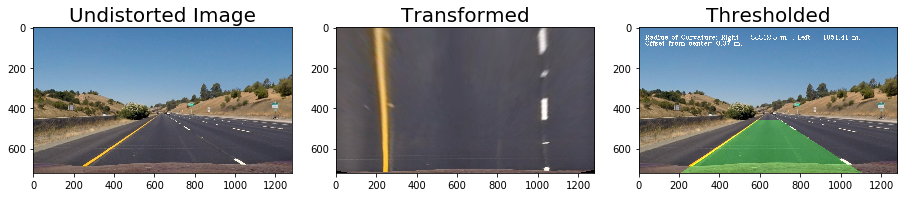

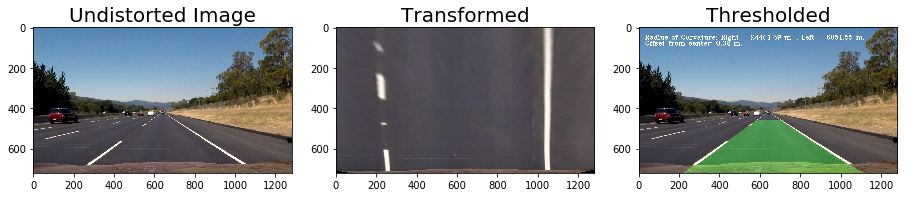

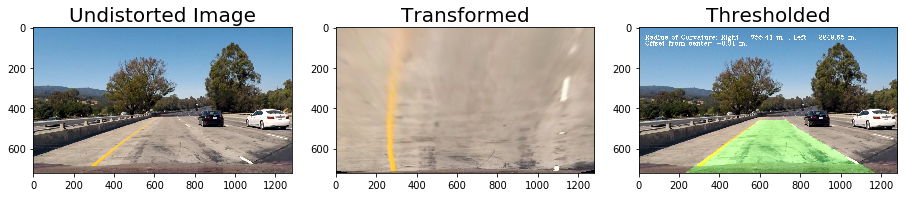

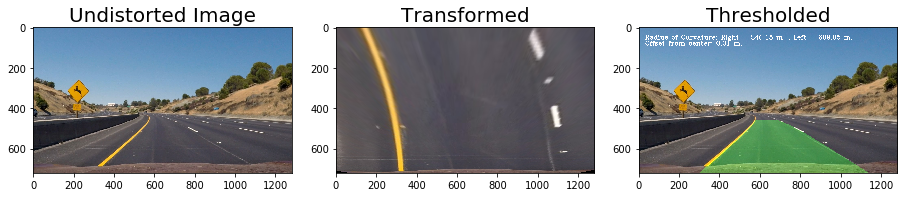

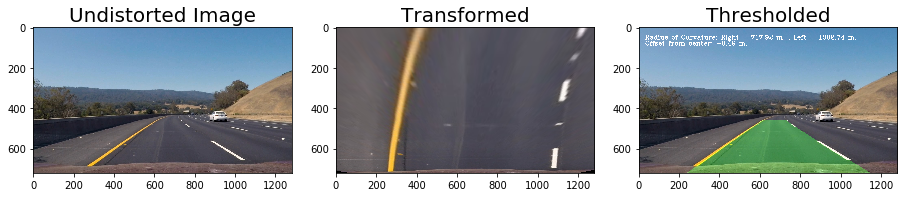

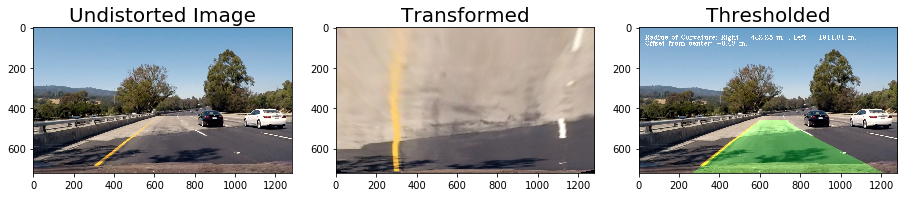

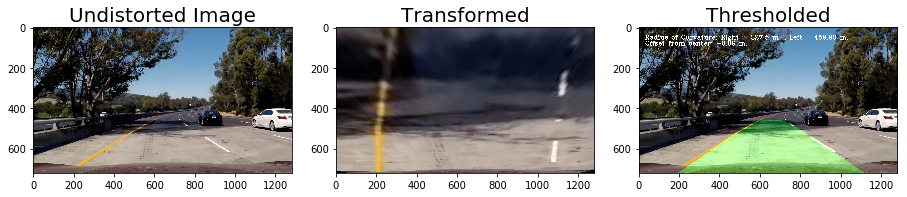

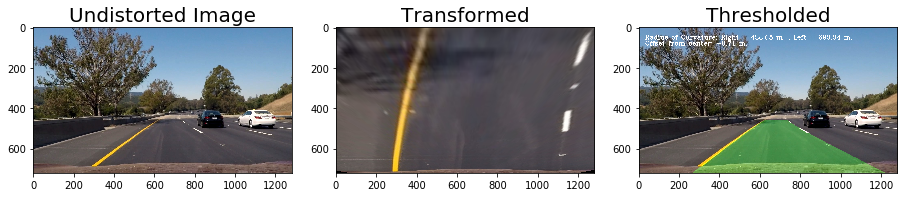

In [217]:
images = os.listdir('./test_images')  
for fname in images:
    fname = os.path.join('test_images',fname)
    img = mpimg.imread(fname)
    #img = cv2.resize(img, (720, 405))
    warped, M, Minv = lane_corners_unwarp(img)
    thresholded = pipeline2(warped)
    result = l_pipeline(img)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 7))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Undistorted Image', fontsize=20)
    ax2.imshow(warped)
    ax2.set_title('Transformed', fontsize=20)
    ax3.imshow(result)
    ax3.set_title('Thresholded', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [218]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

write_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
write_clip = clip1.fl_image(l_pipeline) 
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [06:39<00:00,  3.32it/s]    | 1/1261 [00:00<06:28,  3.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 6min 41s, sys: 1min 43s, total: 8min 24s
Wall time: 6min 39s
